In [10]:
# ============================================
# 0. Imports & paths
# ============================================
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import tensorflow as tf

# ---- EDIT THESE PATHS ----
MODEL_PATH = r"D:\Desktop\Duke 2025 Fall\CS 372\Final Project\Downstream Part\ImageToDEM\Model\pix2pix_Tensorflow\model"
TEST_PT   = r"D:\Desktop\Duke 2025 Fall\CS 372\Final Project\Downstream Part\ImageToDEM\CS372_Data\test_all.pt"
VAL_PT    = r"D:\Desktop\Duke 2025 Fall\CS 372\Final Project\Downstream Part\ImageToDEM\CS372_Data\val_all.pt"

IMG_SIZE = 256   # ImageToDEM was trained on 256x256 tiles

# ============================================
# 1. Load TensorFlow generator
# ============================================
print("Loading ImageToDEM model from:", MODEL_PATH)
generator = tf.saved_model.load(MODEL_PATH)
concrete  = generator.signatures["serving_default"]
INPUT_KEY  = next(iter(concrete.structured_input_signature[1]))
OUTPUT_KEY = next(iter(concrete.structured_outputs))


# ============================================
# 2. RGB preprocessing: 4ch torch -> TF batch
# ============================================
def to_tensor_tf(img_torch: torch.Tensor) -> tf.Tensor:
    """
    img_torch: (C,H,W), usually C=4 (RGB + extra band).
      - Values may be in [0,1], [-1,1], or [0,255].
    We:
      1. Take the first 3 channels as RGB.
      2. Try to map back to 0..255 like Sentinel-2 TCI.
      3. Resize to 256x256.
      4. Normalize to [-1,1] exactly as in the ImageToDEM code: x/127.5 - 1.
      5. Return a TF tensor (1,256,256,3).
    """
    # keep only RGB
    x = img_torch[:3].float()   # (3,H,W)

    # ---- guess current range and map to 0..255 ----
    vmin = float(x.min())
    vmax = float(x.max())

    if vmax <= 1.5 and vmin >= 0.0:
        # probably [0,1]
        x = x * 255.0
    elif vmin >= -1.1 and vmax <= 1.1:
        # probably [-1,1]
        x = (x + 1.0) * 0.5 * 255.0
    # else: assume already ~[0,255]

    x = torch.clamp(x, 0.0, 255.0)

    # ---- resize to 256x256 ----
    x = x.unsqueeze(0)  # (1,3,H,W)
    x = F.interpolate(
        x,
        size=(IMG_SIZE, IMG_SIZE),
        mode="bilinear",
        align_corners=False,
    )                    # (1,3,256,256)

    # ---- [0,255] -> [-1,1] (paper's normalization) ----
    x = x[0].permute(1, 2, 0)   # (H,W,C)
    x = (x / 127.5) - 1.0       # [-1,1]

    # ---- to TF batch ----
    x = tf.convert_to_tensor(x[None, ...], dtype=tf.float32)  # (1,256,256,3)
    return x


# ============================================
# 3. Inference: RGB -> DEM (numpy)
# ============================================
@torch.no_grad()
def infer(img_torch: torch.Tensor) -> np.ndarray:
    """
    img_torch: (C,H,W) torch tensor (C>=3).
    Returns: (256,256) numpy array, float32, normalized DEM.
    """
    x = to_tensor_tf(img_torch)
    out = concrete(**{INPUT_KEY: x})[OUTPUT_KEY]   # (1,H,W,1)
    dem = out.numpy()[0, :, :, 0].astype("float32")
    return dem.copy()   # ensure independent memory


# ============================================
# 4. Metrics & dataset-level evaluation
# ============================================
def metrics(ref: np.ndarray, other: np.ndarray):
    diff = other - ref
    mae  = np.abs(diff).mean()
    rmse = np.sqrt((diff ** 2).mean())
    return mae, rmse


def evaluate(pt_path: str, limit=None):
    """
    Evaluate DEM(cloudy) and DEM(pred) against DEM(clean) on a .pt file.
    .pt is expected to be a dict containing tensors:
      "clean", "cloudy", "pred"  each of shape (N, C, H, W), C>=4.
    """
    data = torch.load(pt_path, map_location="cpu")
    N = data["clean"].shape[0]
    n = N if limit is None else min(limit, N)

    cloud_stats = []
    pred_stats  = []

    for i in range(n):
        clean  = data["clean"][i]
        cloudy = data["cloudy"][i]
        pred   = data["pred"][i]

        dem_clean  = infer(clean)
        dem_cloudy = infer(cloudy)
        dem_pred   = infer(pred)

        cloud_stats.append(metrics(dem_clean, dem_cloudy))
        pred_stats.append(metrics(dem_clean, dem_pred))

    cloud_mean = np.mean(cloud_stats, axis=0)
    pred_mean  = np.mean(pred_stats,  axis=0)

    print(f"{pt_path}: baseline vs CLOUDY -> MAE {cloud_mean[0]:.6f}, RMSE {cloud_mean[1]:.6f}")
    print(f"{pt_path}: baseline vs PRED   -> MAE {pred_mean[0]:.6f}, RMSE {pred_mean[1]:.6f}")
    return cloud_mean, pred_mean


# ============================================
# 5. Visualization helpers
# ============================================
def to_vis(img_torch: torch.Tensor):
    """
    Robust visualization for (C,H,W) image.
    - Uses only first 3 channels.
    - Rescales the actual min/max of that patch to [0,1].
    Works whether data is [0,1], [-1,1], or [0,255].
    """
    x = img_torch[:3].float()   # (3,H,W)
    vmin = float(x.min())
    vmax = float(x.max())
    x = (x - vmin) / (vmax - vmin + 1e-8)  # -> [0,1]
    x = x.permute(1, 2, 0).cpu().numpy()   # (H,W,C)
    x = np.clip(x, 0.0, 1.0)
    return x


def show_sample_DEM_only(pt_path=TEST_PT, idx=0, clip=(1, 99)):
    """
    Show RGB (cloudy, pred, clean) and their DEMs (cloudy->DEM, pred->DEM, clean->DEM).
    No DEM difference panel.
    """
    data = torch.load(pt_path, map_location="cpu")

    cloudy   = data["cloudy"][idx]
    pred_in  = data["pred"][idx]
    clean    = data["clean"][idx]

    # ---- Compute DEMs ----
    dem_cloudy = infer(cloudy)
    dem_pred   = infer(pred_in)
    dem_clean  = infer(clean)

    # ---- Shared DEM color scale ----
    vmin, vmax = np.percentile(
        np.stack([dem_cloudy, dem_pred, dem_clean]), clip
    )

    fig, axes = plt.subplots(2, 3, figsize=(15, 9))

    # =====================
    #   TOP ROW (RGB)
    # =====================
    axes[0, 0].imshow(to_vis(cloudy))
    axes[0, 0].set_title("Cloudy RGB")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(to_vis(pred_in))
    axes[0, 1].set_title("Pred RGB")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(to_vis(clean))
    axes[0, 2].set_title("Clean RGB")
    axes[0, 2].axis("off")

    # =====================
    #   BOTTOM ROW (DEM)
    # =====================
    im0 = axes[1, 0].imshow(dem_cloudy, cmap="terrain", vmin=vmin, vmax=vmax)
    axes[1, 0].set_title("DEM (cloudy → DEM)")
    axes[1, 0].axis("off")

    im1 = axes[1, 1].imshow(dem_pred, cmap="terrain", vmin=vmin, vmax=vmax)
    axes[1, 1].set_title("DEM (pred → DEM)")
    axes[1, 1].axis("off")

    im2 = axes[1, 2].imshow(dem_clean, cmap="terrain", vmin=vmin, vmax=vmax)
    axes[1, 2].set_title("DEM (clean → DEM)")
    axes[1, 2].axis("off")

    # Shared colorbar for all 3 DEMs
    fig.colorbar(im2, ax=axes[1, :], fraction=0.03, pad=0.03, label="Elevation (relative)")

    plt.tight_layout()
    plt.show()

    return dem_cloudy, dem_pred, dem_clean


Loading ImageToDEM model from: D:\Desktop\Duke 2025 Fall\CS 372\Final Project\Downstream Part\ImageToDEM\Model\pix2pix_Tensorflow\model


In [13]:
print("\n=== VAL SET ===")
evaluate(VAL_PT, limit=None)

print("\n=== TEST SET ===")
evaluate(TEST_PT, limit=None)


=== VAL SET ===
D:\Desktop\Duke 2025 Fall\CS 372\Final Project\Downstream Part\ImageToDEM\CS372_Data\val_all.pt: baseline vs CLOUDY -> MAE 0.215648, RMSE 0.234366
D:\Desktop\Duke 2025 Fall\CS 372\Final Project\Downstream Part\ImageToDEM\CS372_Data\val_all.pt: baseline vs PRED   -> MAE 0.071100, RMSE 0.082538

=== TEST SET ===
D:\Desktop\Duke 2025 Fall\CS 372\Final Project\Downstream Part\ImageToDEM\CS372_Data\test_all.pt: baseline vs CLOUDY -> MAE 0.217131, RMSE 0.236358
D:\Desktop\Duke 2025 Fall\CS 372\Final Project\Downstream Part\ImageToDEM\CS372_Data\test_all.pt: baseline vs PRED   -> MAE 0.074932, RMSE 0.086569


(array([0.21713051, 0.23635761], dtype=float32),
 array([0.0749324 , 0.08656946], dtype=float32))


--- Sample idx=0 ---


C:\Users\asus\AppData\Local\Temp\ipykernel_6424\3009544123.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


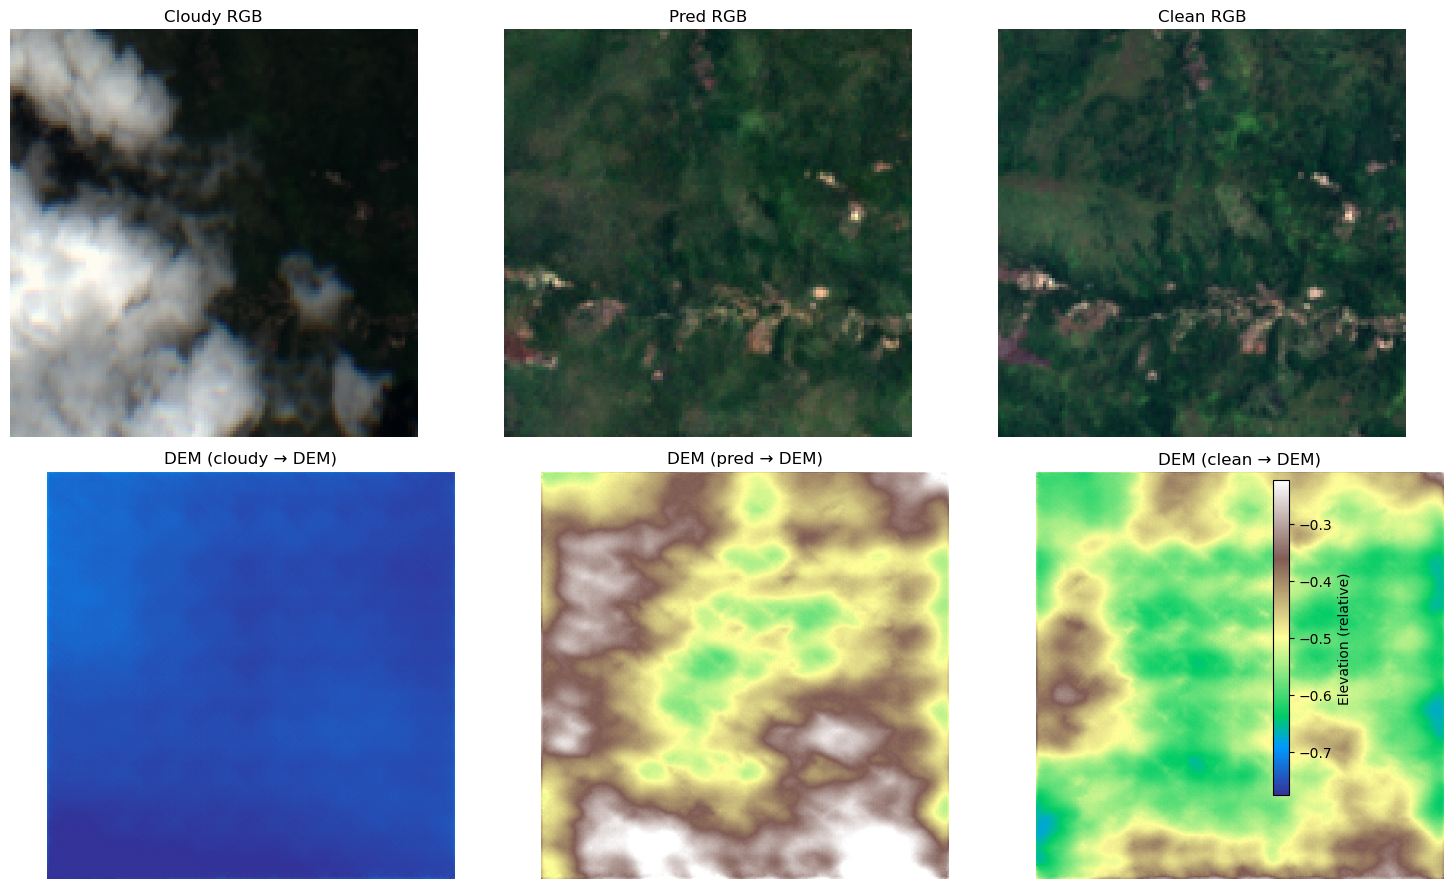


--- Sample idx=90 ---


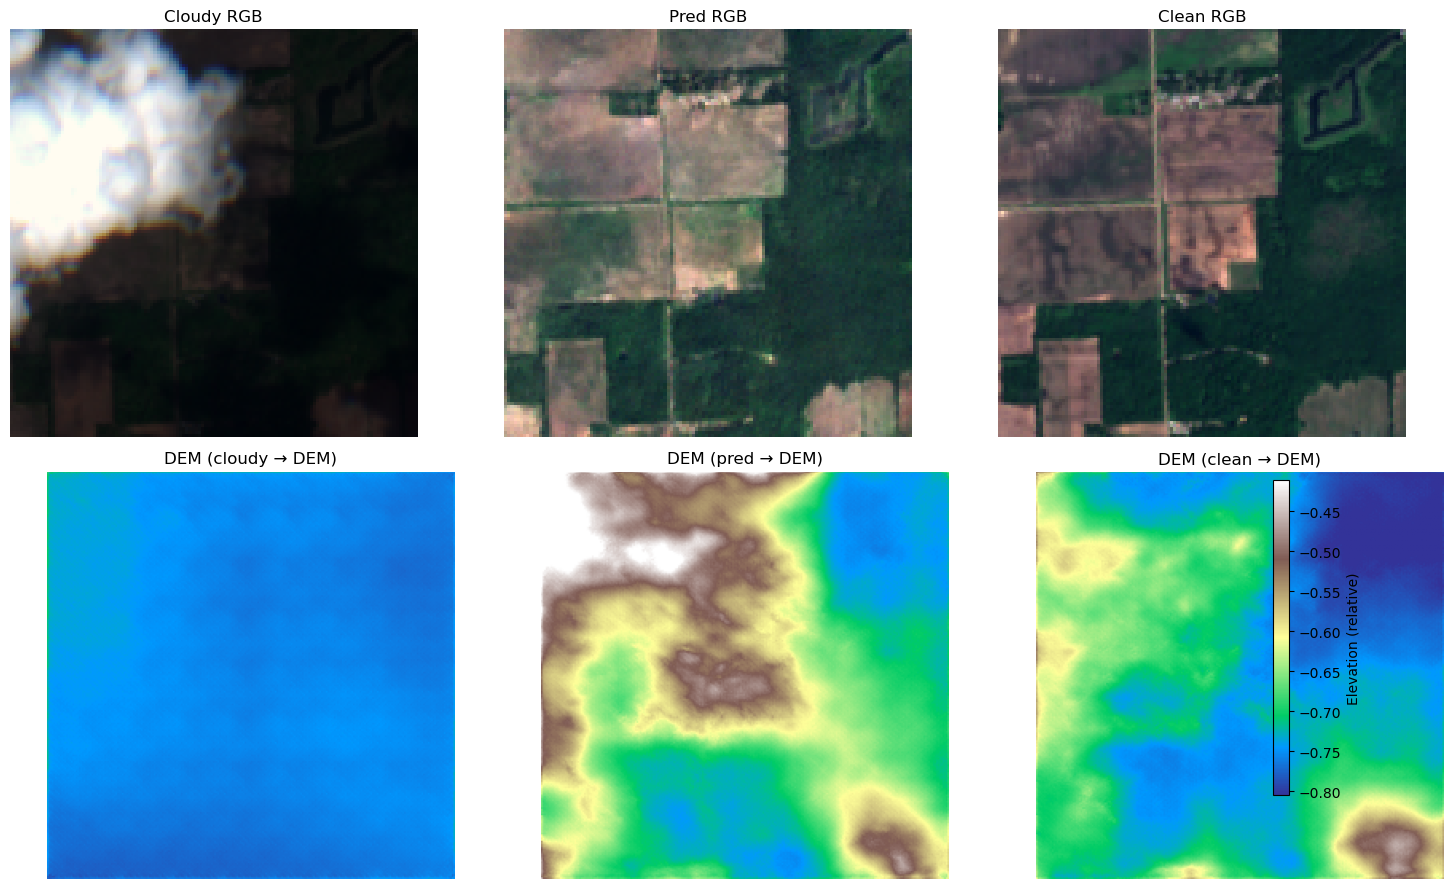


--- Sample idx=10 ---


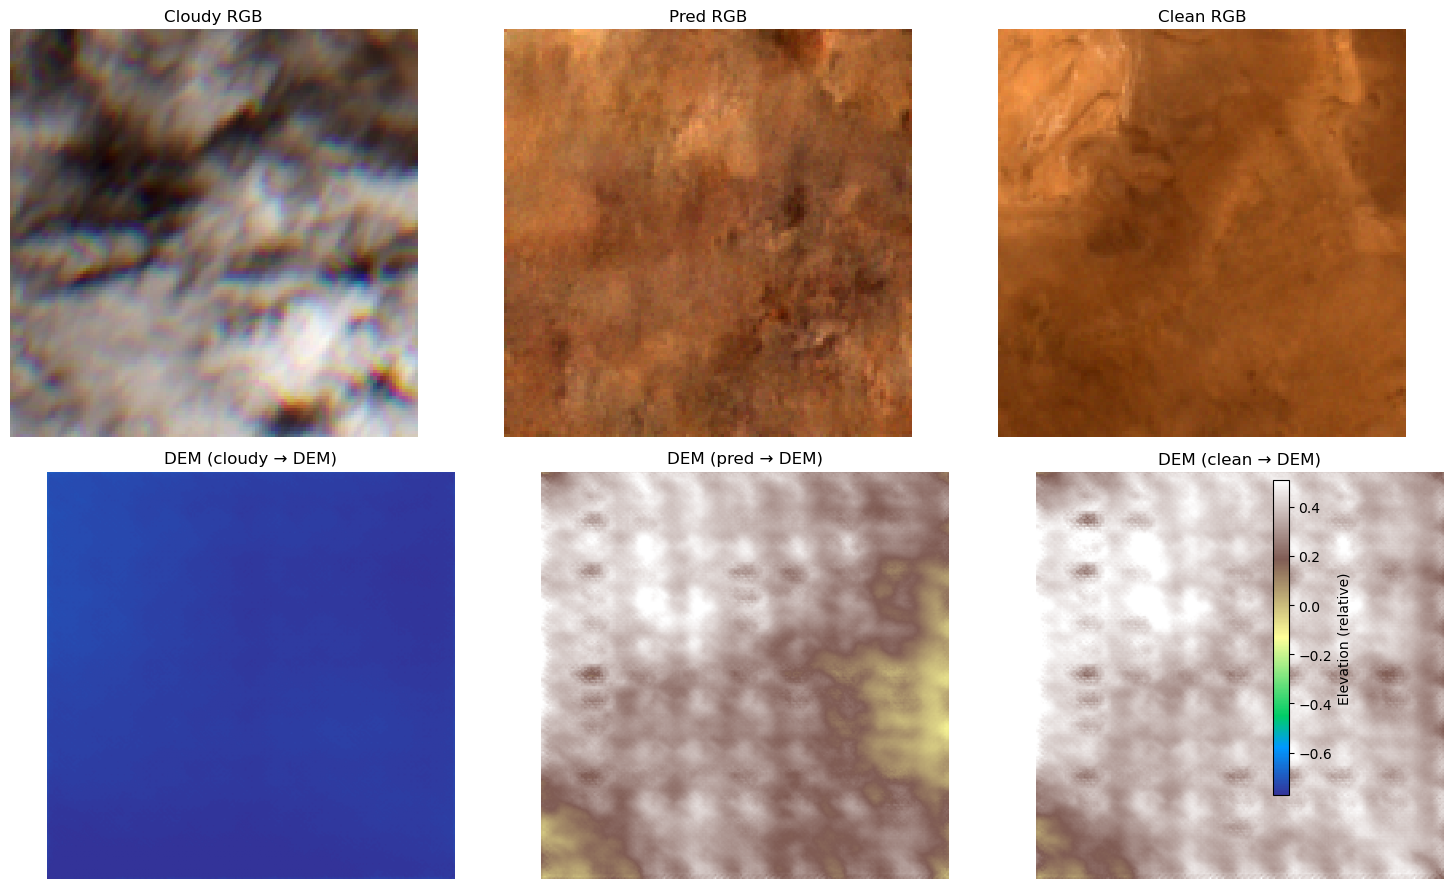


--- Sample idx=20 ---


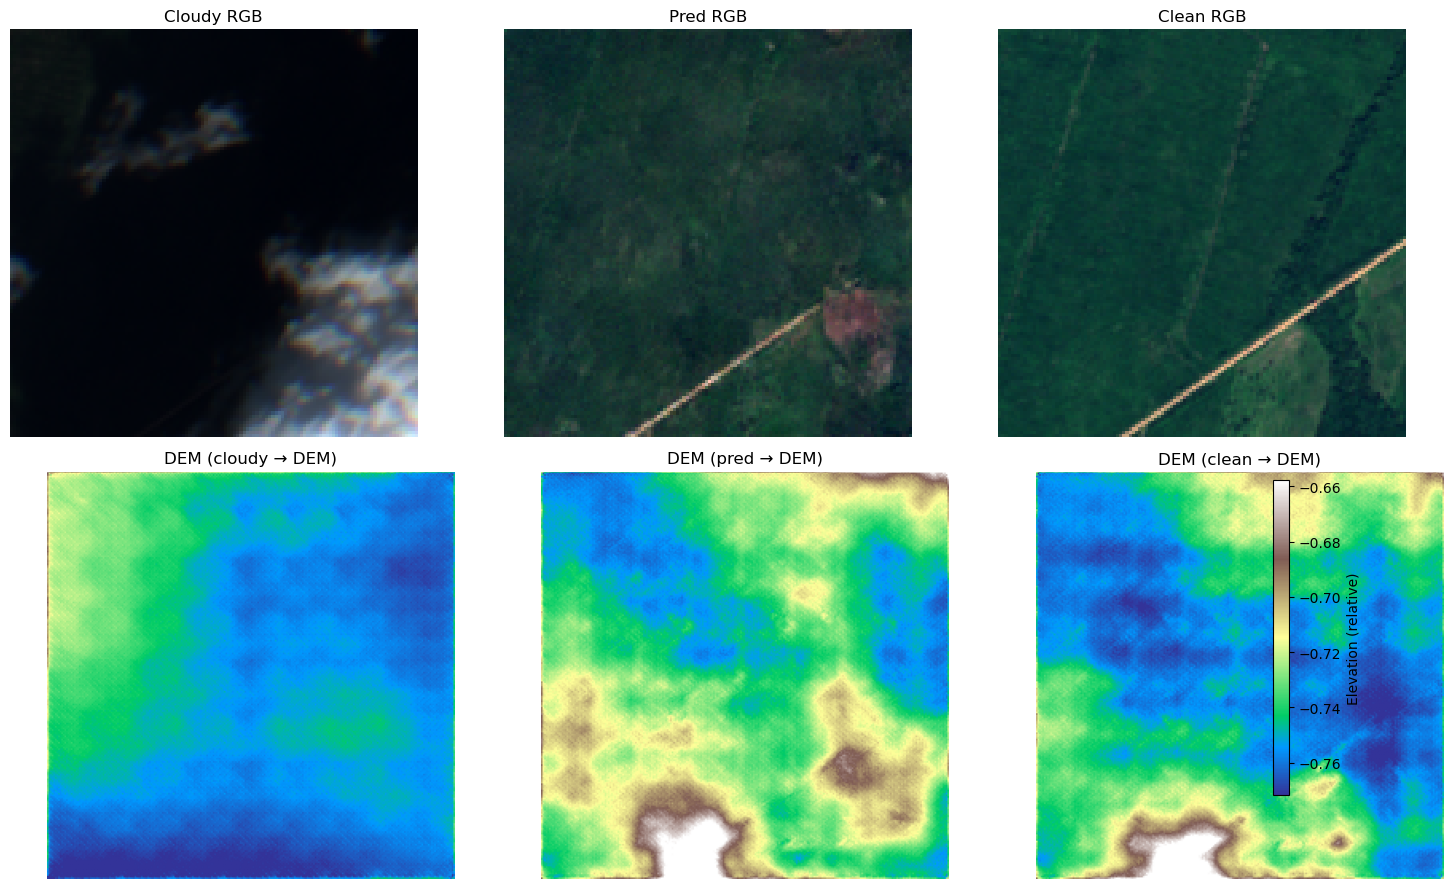

In [15]:

for idx in [0, 90, 10, 20]:
    print(f"\n--- Sample idx={idx} ---")
    show_sample_DEM_only(TEST_PT, idx=idx)
